<a href="https://colab.research.google.com/github/Tahimi/convectionDiffusion/blob/main/lakeModel_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install fipy Gmsh plotly-gif
# uncomment to install fipy, restart (runtime env.) and execute all

In [2]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# read the lack boundary vertices
import pandas as pd

lakeBoundaryVerticesCSV = '/content/drive/MyDrive/UFAL/advection_diffusion/FiniteDiference_FipyFiniteVolume/lakeBoundaryVertices.csv'
df = pd.read_csv(lakeBoundaryVerticesCSV, usecols = ['x', 'y'])

xmin, ymin = min(df['x']), min(df['y'])
df['x'], df['y'] = df['x']-xmin, df['y']-ymin
x, y = df['x'], df['y']

print('xmin = ', xmin, ', ymin = ', ymin, '\n'
      'df.shape = ', df.shape)
df.head(3)

xmin =  753145 , ymin =  8920061 
df.shape =  (285, 2)


,x,y
0,908,0
1,913,6
2,939,32


In [4]:
# define the filterBoundary function
import numpy as np

def filterBoundary(dist_min):
    global x, y
    listOfFilteredVertices = []
    i = 0
    i_max = len(x)
    # select the first vertice
    listOfFilteredVertices.append(i)
    while i < i_max:
        a = np.array([x[i], y[i]])
        j = 1
        # advance the increment j untill enconter the next distante enough vertice
        while i+j < len(x) and np.linalg.norm(a - np.array([x[i+j], y[i+j]])) <= dist_min:
            j += 1
        if i+j >= i_max:
            break
        # the encountred vertice has index = i + the increment j
        i += j
        # adding this vertice to the selection
        listOfFilteredVertices.append(i)
    # check the distant between the last and first vertices
    if np.linalg.norm(a - np.array([x[0], y[0]])) <= dist_min:
        listOfFilteredVertices.pop(-1)
    return listOfFilteredVertices

In [5]:
# get the filtered vertices

dist_min = 30. # (m)
dfFiltered = df.iloc[filterBoundary(dist_min)]

print('dfFiltered.shape = ', dfFiltered.shape)
dfFiltered.head(3)

dfFiltered.shape =  (184, 2)


,x,y
0,908,0
2,939,32
4,970,63


In [6]:
# output filtered vertices of the lack boundary

outputFile = '/content/drive/MyDrive/UFAL/advection_diffusion/FiniteDiference_FipyFiniteVolume/lakeBoundaryVerticesFiltered.csv'
dfFiltered.to_csv(outputFile)

In [7]:
# write the geo file for Gmsh

geoFileName = '/content/drive/MyDrive/UFAL/advection_diffusion/FiniteDiference_FipyFiniteVolume/lakeGeoFile.geo.txt'

def writeGeoFile(fileName = geoFileName):
    global dfFiltered
    x, y, verticesNbr = dfFiltered['x'].tolist(), dfFiltered['y'].tolist(), dfFiltered.shape[0]

    with open(fileName, 'w') as geoFile:
        geoFile.write('lc = '+str(dist_min)+'; // characteristic length of mesh elements\n')
        geoFile.write('\n// defining the points\n')
        pointIdx = 0
        for i in range(verticesNbr):
            txtLine = 'Point('+str(i+1)+') = {'+str(x[i])+','+str(y[i])+','+str(0.)+',lc};\n'
            geoFile.write(txtLine)

        geoFile.write('\n// defining the lines\n')
        linesNbr = verticesNbr
        for i in range(linesNbr):
            txtLine = 'Line('+str(i+1)+') = {'+str(i+1)+','+str(i+2)+'};\n'
            if i == linesNbr-1:
                txtLine = 'Line('+str(i+1)+') = {'+str(i+1)+','+str(1)+'};\n'
            geoFile.write(txtLine)

        geoFile.write('\n// defining the line loop and the plane surface\n')
        geoFile.write('Line Loop(1) = {')
        [geoFile.write(str(i)+',') for i in range(1,linesNbr)]
        geoFile.write(str(linesNbr)+'};\n')
        geoFile.write('Plane Surface(1) = {1};\n')

        geoFileFinalParte='''
// Define the meshing algorithm for the surface
Mesh.Algorithm = 6; // Frontal-Delaunay for quads

// Define the number of cells for the mesh
//Mesh.RecombinationAlgorithm = 2; // full-quad recombination algorithm
//Mesh.RecombineAll = 1;
//Mesh.Smoothing = 10;
//Color Grey50{ Surface{ 1 }; }

// Define the physical groups
Physical Surface("Lagoa") = {1};'''
        geoFile.write(geoFileFinalParte)
        print('successfully generated file:', geoFileName)

writeGeoFile()

successfully generated file: /content/drive/MyDrive/UFAL/advection_diffusion/FiniteDiference_FipyFiniteVolume/lakeGeoFile.geo.txt


In [8]:
# space discretization
from fipy import *

cl = dist_min
mesh = Gmsh2D(geoFileName)
xL, xR = min(mesh.x), max(mesh.x)
yL, yR = min(mesh.y), max(mesh.y)
delX, delY = np.rint(xR-xL), np.rint(yR-yL)
nx, ny = int(delX/dist_min), int(delY/dist_min)

print('caracteristic length, cl (m) = ', cl, '\n'
      'delX (m) = ', delX, ', delY (m) = ', delY, '\n'
      'nx = ', nx, ', ny = ', ny, '\n'
      'number of mesh cells = ', mesh.globalNumberOfCells)

caracteristic length, cl (m) =  30.0 
delX (m) =  2153.0 , delY (m) =  1102.0 
nx =  71 , ny =  36 
number of mesh cells =  6516


In [9]:
# time discretization
from datetime import timedelta

def timeSTR(hours):
    seconds = int(hours*3600)
    return str(timedelta(seconds=seconds))

def daysSTR(hours):
    seconds = int(hours*3600)
    return str(timedelta(seconds=seconds).days)

# simulation time
tL = 0.0
delT = 3*30*24 # (h)
tR = tL + delT

# advection-base time step size
vx, vy = 0.0931*1e3, -0.0386*1e3 # (m/h)
Cr = 0.8 # Courant Number: Cr = u*dt/dx
dtAdv = Cr*cl/max(abs(vx),abs(vy))

# diffusion-base time step size
D = (delX*delY)/(10*24) # (m**2/h)
Fr = 0.8 # Fourier Number: Fr = D*dt/dx**2
dtDiff = abs(Fr*cl**2/D)

# define time step size
dt = 1. #dtAdv #min(dtAdv,dtDiff)

nt = 72 #int(np.rint(delT/dt))
delT = np.rint(nt*dt)
tR = tL + delT
t = np.linspace(tL, tR, nt+1)

print('advection: vx = ', np.rint(vx), ', vy = ', np.rint(vy), ', Cr = u*dt/dx = ', Cr, ', dtAdv = ', timeSTR(dtAdv), '\n'
      'diffusion: D = ', np.rint(D), ', Fr = D*dt/dx**2 = ', Fr, ', dtDiff = ', timeSTR(dtDiff), '\n'
      'time range: tL = ', t[0], ', tR = ', t[-1], ', delT = ', timeSTR(delT), '\n'
      'time step size: dt = ', timeSTR(dt), ', nt = ', nt)

advection: vx =  93.0 , vy =  -39.0 , Cr = u*dt/dx =  0.8 , dtAdv =  0:15:28 
diffusion: D =  9886.0 , Fr = D*dt/dx**2 =  0.8 , dtDiff =  0:04:22 
time range: tL =  0.0 , tR =  72.0 , delT =  3 days, 0:00:00 
time step size: dt =  1:00:00 , nt =  72


In [10]:
# the source center in the grid is the grid cell the closest
# to the given source point

def sourceCenter(sourcePos):
    global mesh
    x, y = mesh.x, mesh.y
    xs1, ys1 = sourcePos
    dist2Source = DistanceVariable(mesh=mesh,
                                   value=numerix.sqrt((x-xs1)**2+(y-ys1)**2))
    sourceClosestCellMask = (dist2Source == dist2Source.min())
    xcs, *_ = x[sourceClosestCellMask]
    ycs, *_ = y[sourceClosestCellMask]
    return (xcs, ycs)

In [11]:
# the source grid mask is the selection of all the grid cells in the vinicity
# of the source center, (boolean selection of mesh elements in fipy)

def sourceGridMask(xcs, ycs, isPonctual=True, width=0., isRectangular=False):
    global mesh
    x, y = mesh.x, mesh.y
    ds = DistanceVariable(mesh=mesh,
                          value=numerix.sqrt((x-xcs)**2+(y-ycs)**2))

    # the source is ponctual (the source is composed of only one grid cell)
    if isPonctual:
        sourceClosestCellMask = (ds == ds.min())
        return sourceClosestCellMask

    # the source shape is rectangular
    if isRectangular:
        return ((xcs-width<x) & (x<xcs+width) \
              & (ycs-width<y) & (y<ycs+width))

    # the source shape is circular
    else:
        return (ds <= width)


In [12]:
# read the polluant sources points

polluantSourcesFileName = '/content/drive/MyDrive/UFAL/advection_diffusion/FiniteDiference_FipyFiniteVolume/lakePolluantSourcesPoints.csv'

dfsource = pd.read_csv(polluantSourcesFileName, usecols = ['x', 'y'])
dfsource['x'], dfsource['y'] = dfsource['x']-xmin, dfsource['y']-ymin

s1Pos, s1Width, s1Value = (dfsource['x'][0], dfsource['y'][0]), cl, 1.
s2Pos, s2Width, s2Value = (dfsource['x'][1], dfsource['y'][1]), cl, 1.
s3Pos, s3Width, s3Value = (dfsource['x'][2], dfsource['y'][2]), cl, 1.

In [13]:
# initialization

zMin = 0.
sigmma = 0.25*1e-8 # (1/h)
def initialize():
    # preparing the sources terms
    global s1Pos, s1Width, s1Value
    xcs1, ycs1 = sourceCenter(sourcePos=s1Pos)
    s1Mask = sourceGridMask(xcs=xcs1, ycs=ycs1)
    global s2Pos, s2Width, s2Value
    xcs2, ycs2 = sourceCenter(sourcePos=s2Pos)
    s2Mask = sourceGridMask(xcs=xcs2, ycs=ycs2)
    global s3Pos, s3Width, s3Value
    xcs3, ycs3 = sourceCenter(sourcePos=s3Pos)
    s3Mask = sourceGridMask(xcs=xcs3, ycs=ycs3)

    # unkown's initialization
    global mesh, zMin, zInit, z
    zInit = CellVariable(mesh=mesh, value=zMin)
    zInit.setValue(s1Value, where=s1Mask)
    zInit.setValue(s2Value, where=s2Mask)
    zInit.setValue(s3Value, where=s3Mask)
    z = CellVariable(mesh=mesh, value=zInit)

    # Applying noFlow BC
    z.faceGrad.constrain((0.,), where=mesh.exteriorFaces)

    # Defining the discritized equation
    global vx, vy, D, sigmma, eq
    eq = (TransientTerm(coeff=1.0)
       + PowerLawConvectionTerm(coeff=(vx,vy))
       == DiffusionTerm(coeff=D)
       + ImplicitSourceTerm(coeff=-sigmma)
       - ImplicitSourceTerm(s1Mask * 1e+10) + s1Mask * 1e+10 * s1Value
       - ImplicitSourceTerm(s2Mask * 1e+10) + s2Mask * 1e+10 * s2Value
       - ImplicitSourceTerm(s3Mask * 1e+10) + s3Mask * 1e+10 * s3Value)

# initialize the discritized model
initialize()

Initial distribution


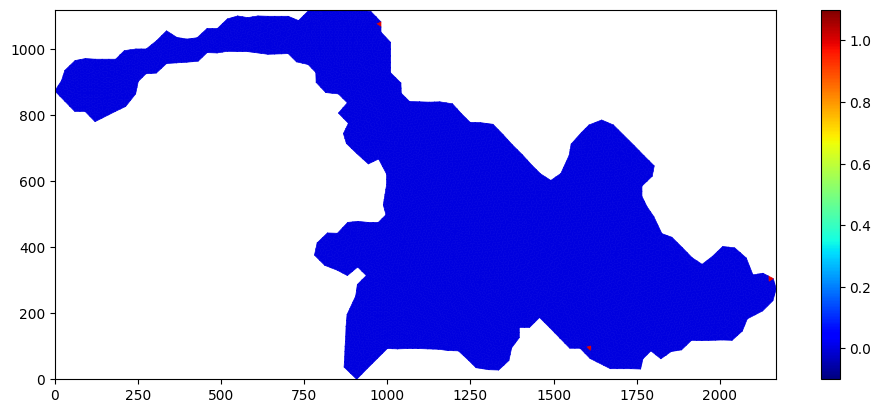

In [14]:
# ploting the unkown's initial distribution

print('Initial distribution')
viewer = Viewer(vars = (zInit),
                datamin = zInit.min()-.1,
                datamax = zInit.max()+.1)
lakePolluant_zInit_PNG = '/content/drive/MyDrive/UFAL/advection_diffusion/FiniteDiference_FipyFiniteVolume/lakePoluant_zInit.png'
viewer.plot(lakePolluant_zInit_PNG)

In [15]:
# defining the time-step update function

def advectAndDiffuse1(z, dt):
    eq.solve(var=z, dt=dt)

In [16]:
# definig the time instants for the saving of y

dt4saving = 24 # (h)
delIdx = int(np.rint(dt4saving/dt))
save_times = t[range(0, len(t), delIdx)]

closest_idx = lambda val, arr: np.abs(arr - val).argmin()
save_indices = [closest_idx(save_time, t) for save_time in save_times]

print('save_times = ', save_times, '\n'
      'save_indices = ', save_indices)

save_times =  [ 0. 24. 48. 72.] 
save_indices =  [0, 24, 48, 72]


In [17]:
# Loop over time, calculate z(t,x,y) and save it at save_times
import pandas as pd

# create a pandas data frame  to save data
dfSavedResults = pd.DataFrame(data={'x':mesh.x, 'y':mesh.y})

# define time's and df column's names upon time value
tiSTR = lambda ti: str(round(ti,3))
zColumnName = lambda ti: f'z_{tiSTR(ti)}'

# iterate over time
for i, ti in enumerate(t):
    if i in save_indices:
        dfSavedResults[zColumnName(ti)] = z
    advectAndDiffuse1(z, Fr)

# display dataframe head
dfSavedResults.head(3)

,x,y,z_0.0,z_24.0,z_48.0,z_72.0
0,1476.994502,300.530549,0.0,0.128586,0.193606,0.224215
1,939.189257,1110.202170,0.0,0.435921,0.439670,0.441319
2,1740.675557,307.084900,0.0,0.200440,0.265726,0.292961


In [18]:
# output the sim results into a csv file

outputFile = '/content/drive/MyDrive/UFAL/advection_diffusion/FiniteDiference_FipyFiniteVolume/lakePolluant_savedResults.csv'
dfSavedResults.to_csv(outputFile)

Distribution after 3 days, 0:00:00


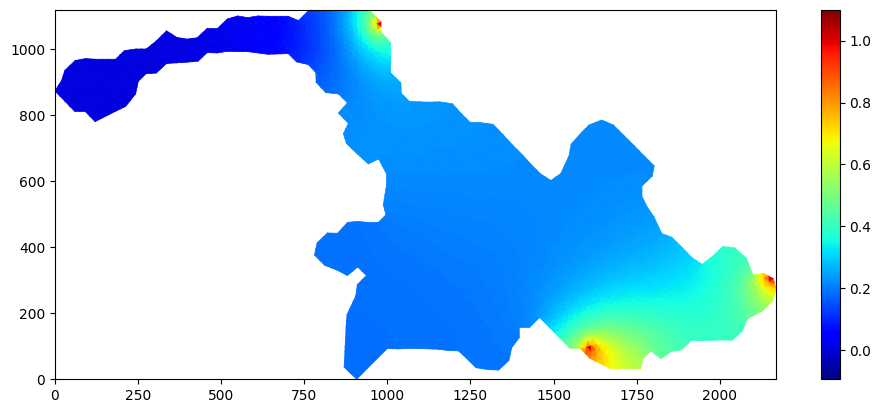

In [19]:
# ploting the unkown's final distribution

print('Distribution after', timeSTR(delT))
viewer = Viewer(vars = (z),
                datamin = z.min()-.1,
                datamax = z.max()+.1)
lakePolluant_z_PNG = '/content/drive/MyDrive/UFAL/advection_diffusion/FiniteDiference_FipyFiniteVolume/lakePolluant_z.png'
viewer.plot(lakePolluant_z_PNG)

# results post-processing (making contour plot and animation)

In [20]:
# interpolate z-values at regular grid vertices
from scipy.interpolate import griddata
from shapely.geometry import Polygon
from shapely.geometry import Point

# define the rigular grid
nxr, nyr = 2*nx+1, 2*ny+1
xr = np.linspace(xL, xR, nxr)
yr = np.linspace(yL, yR, nyr)
[X, Y] = np.meshgrid(xr, yr)

# maing mask for the vertices of the regular grid that are outside the lack
vertices = list(map(tuple, np.asarray(dfFiltered)))
lakeShapelyPolygon = Polygon(vertices)
contains = np.vectorize(lambda p: lakeShapelyPolygon.contains(Point(p)), signature='(n)->()')
regularGridPointsColumnVector = np.array((X,Y)).T.reshape(-1, 2)
lakeRegularGridMask = contains(regularGridPointsColumnVector)

def zAtRegularGridVertices(z):
    global mesh, X, Y

    # interpolate z-values at the regular grid vertices
    zr = griddata((mesh.x, mesh.y), z, (X, Y) , method='linear')

    # (interpolated) z-valuees outside of the lack must be NaN (to not interfere in contour plotting)
    Z = zr.T.reshape(-1, 1)
    Z[~lakeRegularGridMask] = np.nan
    Z = Z.reshape(nxr,nyr).T
    return Z

In [21]:
# defining contour lines distribution
import plotly.graph_objects as go

def goFigure(z, title_text, ncontours=6):
    # computing z values at the rigular grid vertices by interpolation
    Z = zAtRegularGridVertices(z=z)

    # plot data
    data = go.Contour(x=xr, y=yr, z=Z,
                      colorscale='Jet', contours=dict(start=0.,
                                                      end=1.,
                                                      size=0.2,
                                                      coloring='fill'))
    fig = go.Figure(dict({"data": data,
                          "layout": {"title": {"text": title_text},
                                     "title_x":0.5,
                                     'xaxis_title':'East-West (Km)', 'yaxis_title':'South-North (Km)',
                                     "width":800, "height":500}}))
    return fig

In [22]:
fig = goFigure(z=z,
               title_text='Day '+daysSTR(t[-1]))

pngFileName = '/content/drive/MyDrive/UFAL/advection_diffusion/FiniteDiference_FipyFiniteVolume/lackModel_z.png'
fig.write_image(pngFileName)

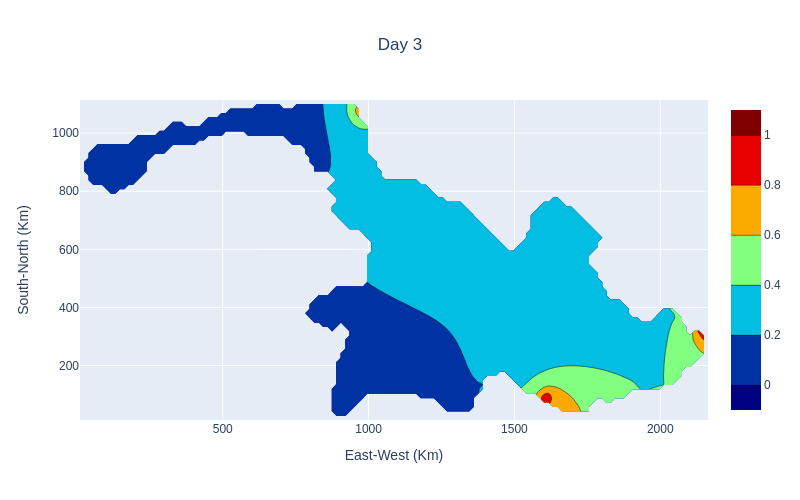

In [23]:
# displaying the image
from IPython.display import Image

Image(open(pngFileName,'rb').read())

In [24]:
# making the gif image
from plotly_gif import GIF

gifFileName = '/content/drive/MyDrive/UFAL/advection_diffusion/FiniteDiference_FipyFiniteVolume/lackModel_z.gif'
gif = GIF(mode="png", gif_name=gifFileName, verbose=True)

for ti in save_times:
    fig = goFigure(z=dfSavedResults[zColumnName(ti)],
                   title_text='Day '+daysSTR(ti))
    gif.create_image(fig)
gif.create_gif()

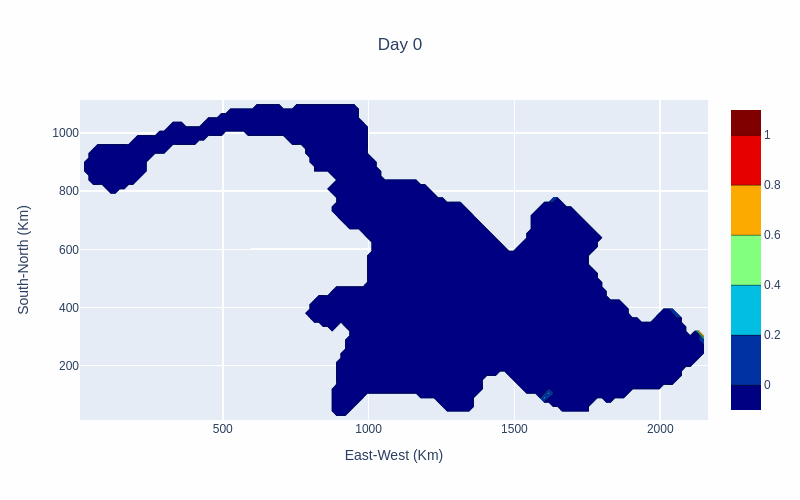

In [25]:
# displaying the animation
from IPython.display import Image

img = Image(open(gifFileName,'rb').read(), embed=True)
display(img)

In [26]:
# make a costumized animation display with a play button
from plotly import express as px

def goFrame(ti):
    # computing z values at the rigular grid vertices by interpolation
    Z = zAtRegularGridVertices(z=dfSavedResults[zColumnName(ti)])

    # plot data
    data = go.Contour(x=xr, y=yr, z=Z,
                      colorscale='Jet', contours=dict(start=0.,
                                                      end=1.,
                                                      size=0.2,
                                                      coloring='fill'))
    return go.Frame(data=data)

# make the initial figure
fig = goFigure(z=dfSavedResults[zColumnName(ti=save_times[0])],
               title_text='Day '+daysSTR(0))

# insert the frames into the figure and set each frame's title_text
fig.update(frames=[goFrame(ti=ti) for ti in save_times]);
for i in range(len(fig.frames)):
    fig.frames[i]['layout'].update(title_text='Day '+daysSTR(save_times[i]))

# make the update menu and insert the play button
fig.update_layout(updatemenus=[dict(type='buttons',
                                    x=-0.1, y=-0.15,
                                    xanchor='left', yanchor='bottom',
                                    buttons = [dict(
                                               args = [None, {"frame": {"duration": 50,
                                                                        "redraw": True},
                                                              "fromcurrent": True,
                                                              "transition": {"duration": 0}}],
                                               label = "Play",
                                               method = "animate")],
                                showactive=True)])
#fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 200
fig.show()